In [1]:
def subsample_labels(df, labels):
    return df.loc[df['label'].isin(labels)]

In [2]:
def remove_au_features(df, au_list):
    for au in au_list:
        df.drop([f'AU{au}_std', f'AU{au}_mean', f'AU{au}_e0_length', f'AU{au}_e1_length', f'AU{au}_e2_length',
                f'AU{au}_e0_amount', f'AU{au}_e1_amount', f'AU{au}_e2_amount',
                f'AU{au}_e0_intensity', f'AU{au}_e1_intensity', f'AU{au}_e2_intensity'], axis=1, inplace=True)


In [3]:
def over_sample(df, label_='happy', amount=95):
    df_happy = df[df.label == label_]
    df_happy = resample(df_happy,
                        replace=True,     # sample with replacement
                        n_samples=amount,    # to match majority class
                        random_state=42) # reproducible results

    return pd.concat([df, df_happy])

In [4]:
def fix_label_name(df):
    for emotion in ['happy', 'angry', 'neutral', 'sad']:
        df = df.replace(f'{emotion}.csv', emotion)
    return df

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, accuracy_score
from sklearn.utils import resample



df = pd.read_csv('results/feature_vector.csv', index_col=0)
# df = fix_label_name(df)
# df = df[df['group'] == 'coda_speak'] #'hearing', 'C', D

df = df.replace('coda_speech', 'speaking')
df = df.replace('hear', 'speaking')
df = df.replace('coda_sign', 'signing')
df = df.replace('deaf', 'signing')

# df = df.replace('angry', 'angry_sad')
# df = df.replace('sad', 'angry_sad')


#Over sample
# df = over_sample(df, 'happy', 336-169)
# df = over_sample(df, 'neutral', 336-169)


label_names = ['sad', 'neutral'] #['angry','happy', 'neutral', 'sad'] #['neutral', 'angry']
df = subsample_labels(df, label_names)

df = df[df['group'] == 'speaking']

# remove_au_features(df, ['10','12','15','17'])

labels = df['label']
# labels = df['group']
group = df['group']

df_copy = df.copy()
df.drop(['label', 'group'], axis=1, inplace=True)
len(labels)

198

In [154]:
group.value_counts()

speaking    198
Name: group, dtype: int64

In [155]:
# pd.unique(labels)
labels.value_counts()

neutral    100
sad         98
Name: label, dtype: int64

In [156]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, random_state=0, test_size=0.3, stratify=labels)

In [157]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
md = 7

clf = RandomForestClassifier(criterion='entropy', max_depth=md)
cv_scores = cross_val_score(clf, df, labels, cv=10)

print(cv_scores)
print(np.mean(cv_scores))

[0.75       0.7        0.65       0.5        0.5        0.5
 0.55       0.65       0.63157895 0.42105263]
0.5852631578947369


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


def plot_importance(feature_imp_):
    print(len(feature_imp_))
    feature_imp_ = feature_imp_[0:5]
    print(feature_imp_)

    sns.barplot(x=feature_imp_, y=feature_imp_.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Feature Importance Score")
    # plt.title("Hearing - Vs. None hearing")
#     plt.legend()
    plt.show()

    

def scatter_imp_features(feature_imp_, label_key='group', i1=0, i2=1):
    df_ = df_copy
  
    plt.figure()
    plt.figure(figsize=(10,6))

    for lab, color in zip(list(labels.value_counts().keys()), ['r', 'b', 'g', 'k']):
        f1 = list(df_[df_[label_key] == lab][feature_imp_.keys()[i1]])
        f2 = list(df_[df_[label_key] == lab][feature_imp_.keys()[i2]])
        plt.scatter(f1,f2, c=color, label=lab)
        
    plt.legend()
    plt.xlabel(feature_imp_.keys()[i1])
    plt.ylabel(feature_imp_.keys()[i2])


def hist_imp_features(feature_imp_, label_key='group', i1=0):
    df_ = df_copy
  
    plt.figure()
    plt.figure(figsize=(10,6))

    for lab, color in zip(list(labels.value_counts().keys()), ['r', 'b', 'g', 'k']):
        f1 = list(df_[df_[label_key] == lab][feature_imp_.keys()[i1]])
        plt.hist(f1, 20, facecolor=color, label=lab, alpha=0.75)
        
    plt.legend()
    plt.xlabel(feature_imp_.keys()[i1])


              precision    recall  f1-score   support

     neutral       0.54      0.43      0.48        30
         sad       0.53      0.63      0.58        30

    accuracy                           0.53        60
   macro avg       0.53      0.53      0.53        60
weighted avg       0.53      0.53      0.53        60

f1: 0.5286195286195287
prec: 0.5347222222222222
accuracy: 0.5333333333333333
max_depth: 7
121
AU07_std     0.038986
AU15_mean    0.030387
AU04_std     0.030057
AU07_mean    0.025887
AU04_mean    0.025425
dtype: float64


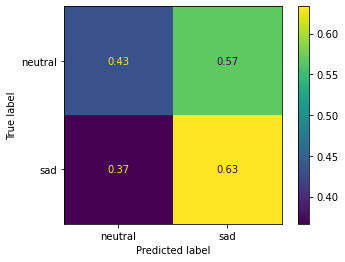

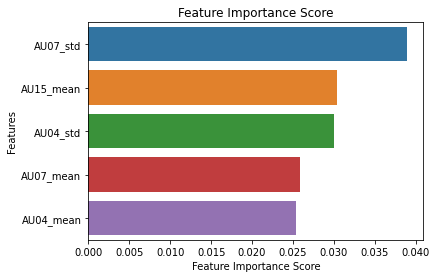

<Figure size 432x288 with 0 Axes>

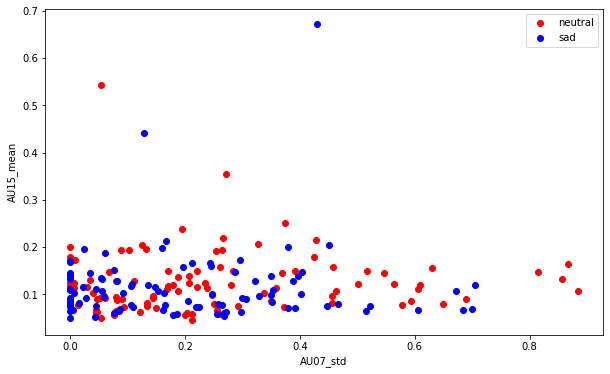

<Figure size 432x288 with 0 Axes>

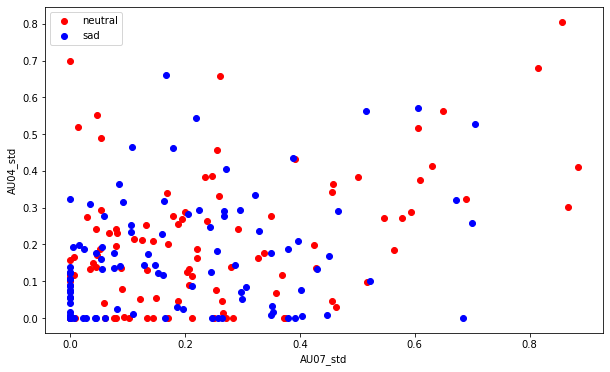

<Figure size 432x288 with 0 Axes>

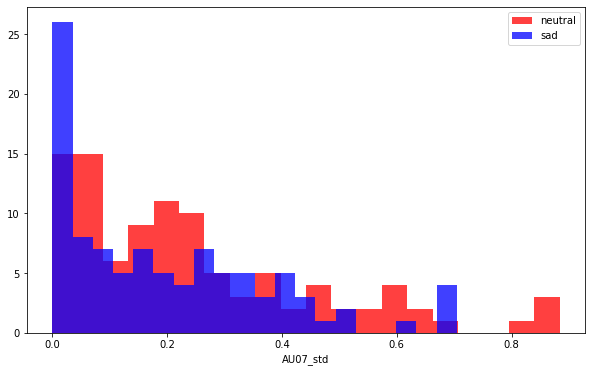

In [158]:
# xtrain = X_train[feature_imp[0:200].index.to_list()]
# xtest = X_test[feature_imp[0:200].index.to_list()]

xtrain = X_train
xtest = X_test

clf = RandomForestClassifier(criterion='entropy', max_depth=7)
clf.fit(xtrain, y_train)
feature_imp_ = pd.Series(clf.feature_importances_,index=df.columns.tolist()).sort_values(ascending=False)

y_pred = clf.predict(xtest)
print(classification_report(y_test, y_pred, labels=clf.classes_))
f1_ = f1_score(y_test, y_pred, average='macro')
prec = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

print(f'f1: {f1_}')
print(f'prec: {prec}')
print(f'accuracy: {accuracy}')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.figure()
print('max_depth:', md)

plot_importance(feature_imp_)
scatter_imp_features(feature_imp_, 'label') # in Task2 change to 'label'
scatter_imp_features(feature_imp_, 'label',0,2)
hist_imp_features(feature_imp_, 'label',0)


              precision    recall  f1-score   support

   angry_sad       0.89      0.99      0.94       309
       happy       0.98      0.94      0.96       309
     neutral       1.00      0.93      0.96       309

    accuracy                           0.95       927
   macro avg       0.96      0.95      0.95       927
weighted avg       0.96      0.95      0.95       927

f1: 0.9541221466816671
prec: 0.9574592703844406
max_depth: 7


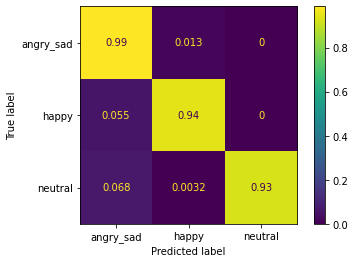

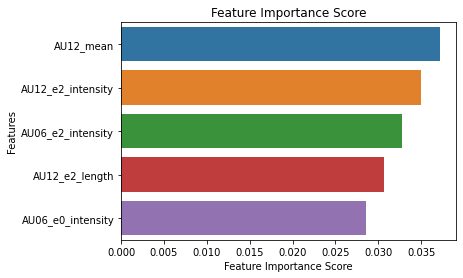

In [47]:
# overfit 
md = 7
clf = RandomForestClassifier(criterion='entropy', max_depth=md)
clf.fit(df, labels)

y_pred = clf.predict(df)
print(classification_report(labels, y_pred, labels=clf.classes_))
f1_ = f1_score(labels, y_pred, average='macro')
prec = precision_score(labels, y_pred, average='macro')
print(f'f1: {f1_}')
print(f'prec: {prec}')

cm = confusion_matrix(labels, y_pred, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.figure()
print('max_depth:', md)
plot_importance(clf)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:05<00:00,  2.63s/it]

features: 53 cv: 0.8763157894736843 


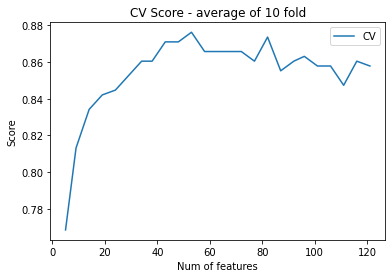

In [7]:
# cv score average per feature on the x -axis
from tqdm import tqdm
cv_aver = []
fe_range = np.linspace(5, 121, 25).astype(int)
for num_features in tqdm(fe_range):
    df_ = df[feature_imp[0:num_features].index.to_list()]
    clf = RandomForestClassifier(criterion='entropy', max_depth=11)
    cv_scores = cross_val_score(clf, df_, labels, cv=10)
    cv_aver.append(np.mean(cv_scores))

plt.plot(fe_range, cv_aver, label='CV')
plt.xlabel('Num of features')
plt.ylabel('Score')
plt.title('CV Score - average of 10 fold')
plt.legend()


max_idx = np.argmax(cv_aver)
features_max = fe_range[max_idx]
print(f'features: {features_max} cv: {cv_aver[max_idx]} ')

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=3)
clf.fit(df, y)


fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf, filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')


In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
# clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=3)
# clf.fit(df, labels)

fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf.estimators_[0], filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')


In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
# clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=3)
# clf.fit(df, labels)

fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf.estimators_[0], filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')
